In [1]:
# Standard imports
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns

# using inline, have to set the figure bigger
%matplotlib inline

# set figure parameters so they look pretty
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (9.5, 6),
         'axes.labelsize': 12,
         'axes.titlesize': 14,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12,
         'axes.spines.right' : False,
         'axes.spines.left' : False,
         'axes.spines.top' : False,
         'axes.spines.bottom' : False}
pylab.rcParams.update(params)

# I like to have more colors than what are available, so define tableau20 colors:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

# Data Exploration

Read in the data, convert it to useful date information, and look at the general S&P 500 trend.

In [2]:
# load in the S&P 500 historical data
sp500_df = pd.read_csv('../data/GSPC.csv')

# define an array that measures in years -- we'll need it for fitting later

# convert everything to a datetime object
sp500_df['Date']      = pd.to_datetime(sp500_df.Date)
sp500_df['DayOfYear'] = sp500_df.Date.dt.dayofyear
sp500_df['Year']      = sp500_df.Date.dt.year
sp500_df['Month']     = sp500_df.Date.dt.month
sp500_df['Dat']       = sp500_df.Date.dt.day

t_years = np.array(list(range(0, np.shape(sp500_df['Open'])[0])))/365.

In [3]:
# take a peak at the structure of the data
sp500_df.head()
sp500_df.tail()

sp500_df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfYear,Year,Month,Dat
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0,364,1927,12,30
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0,3,1928,1,3
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0,4,1928,1,4
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0,5,1928,1,5
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0,6,1928,1,6


,Date,Open,High,Low,Close,Adj Close,Volume,DayOfYear,Year,Month,Dat
23130,2020-02-03,3235.659912,3268.439941,3235.659912,3248.919922,3248.919922,3757910000,34,2020,2,3
23131,2020-02-04,3280.610107,3306.919922,3280.610107,3297.590088,3297.590088,3995320000,35,2020,2,4
23132,2020-02-05,3324.909912,3337.580078,3313.750000,3334.689941,3334.689941,4117730000,36,2020,2,5
23133,2020-02-06,3344.919922,3347.959961,3334.389893,3345.780029,3345.780029,3868370000,37,2020,2,6
23134,2020-02-07,3335.540039,3341.419922,3322.120117,3327.709961,3327.709961,3730650000,38,2020,2,7


,Open,High,Low,Close,Adj Close,Volume,DayOfYear,Year,Month,Dat
count,23135.000000,23135.000000,23135.000000,23135.000000,23135.000000,2.313500e+04,23135.000000,23135.000000,23135.000000,23135.000000
mean,465.417805,468.087517,462.591294,465.521319,465.521319,7.337330e+08,182.776832,1973.639378,6.510741,15.759888
std,688.539723,691.981567,684.823107,688.661500,688.661500,1.432321e+09,104.890424,26.570625,3.432909,8.740327
min,4.400000,4.400000,4.400000,4.400000,4.400000,0.000000e+00,2.000000,1927.000000,1.000000,1.000000
25%,23.700001,23.700001,23.700001,23.700001,23.700001,1.230000e+06,92.000000,1951.000000,4.000000,8.000000
50%,98.940002,99.709999,98.110001,98.930000,98.930000,1.673000e+07,182.000000,1974.000000,7.000000,16.000000
75%,759.170013,766.820007,753.035004,759.505005,759.505005,4.773700e+08,273.000000,1997.000000,9.000000,23.000000
max,3344.919922,3347.959961,3334.389893,3345.780029,3345.780029,1.145623e+10,366.000000,2020.000000,12.000000,31.000000


//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


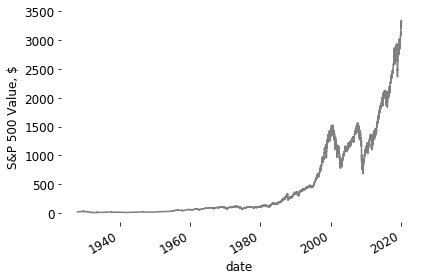

In [4]:
# lets look at the long term trend for the opening value
fig, ax = plt.subplots()
ax.plot(sp500_df.Date, sp500_df.Open, c='tab:gray')
ax.set_xlabel('date', fontsize=12)
ax.set_ylabel('S&P 500 Value, $', fontsize=12)

fig.autofmt_xdate()

fig.tight_layout()
fig.savefig('sp500.png', bbox_inches="tight");
fig.show();

There is an exponential-looking growth here, so looking at this on a semilog plot might be helpful

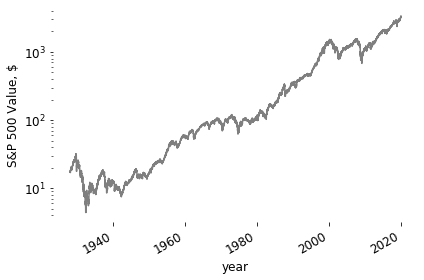

In [5]:
# Compare the fit to the real data on a semi-log plot
fig, ax = plt.subplots()
ax.semilogy(sp500_df.Date, sp500_df['Open'], c='tab:gray', label='S&P 500 data')
ax.set_xlabel('year')
ax.set_ylabel('S&P 500 Value, $')

#ax.legend()
fig.autofmt_xdate()

fig.tight_layout()
fig.savefig('sp500_semilog.png', bbox_inches="tight");

# Fitting the mean growth

This curve looks like it may have some exponential growth trend to it, so it would be good to isolate the exponential growth and look at a time-normalized value for the S&P 500.

We will fit a curve of the form

$\textrm{val} = \textrm{val}(0) \exp[t/\tau]$

to find the growth constant $\tau$ that tells us the rate per trading day of S&p 500 growth. We will then subtract off this general trend line to look at shorter-time variations.

In [6]:
# Fit an exponential curve to the closing date, so we can normalize to the local average
oneOtau, a = np.polyfit(t_years, np.log(sp500_df['Open']), 1)
exp_fit = np.exp(oneOtau * t_years + a)

print('time constant tau = {} trading years'.format(1/oneOtau))

time constant tau = 10.514183396623846 trading years


Because of the exponential growth over many growth cycles, comparing goodness of fit to the data is best done visually on a semi-log plot. Exponential growth will appear as a straight line with slope $1/\tau$

Text(0.5, 0, 'year')

Text(0, 0.5, 'S&P 500 Value, $')

exponential e-fold growth time = 10.514183396623846 years


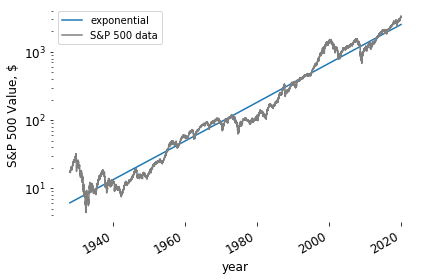

In [7]:
# Compare the fit to the real data on a semi-log plot
fig, ax = plt.subplots()
ax.semilogy(sp500_df.Date, exp_fit, c='tab:blue', label='exponential')
ax.semilogy(sp500_df.Date, sp500_df['Open'], c='tab:gray', label='S&P 500 data')
ax.set_xlabel('year')
ax.set_ylabel('S&P 500 Value, $')

ax.legend()
fig.autofmt_xdate()

fig.tight_layout()
fig.savefig('exp_fit.png', bbox_inches="tight");

print('exponential e-fold growth time = {} years'.format(1/oneOtau))

## Historical Context

That's a pretty consistent exponential growth from the bottom of the Great Depression, around 1933, until today. It might help to look at those bumps and dips in historical context.

Text(1929-10-29 00:00:00, 55, 'Great Depression')

Text(1941-12-07 00:00:00, 4, 'World War II')

Text(1973-10-01 00:00:00, 25, 'Energy Crisis')

Text(1990-11-09 00:00:00, 3000, 'Dot-Com Bubble')

Text(1998-09-20 00:00:00, 200, 'Great Recession')

Text(0.5, 0, 'year')

Text(0, 0.5, 'S&P 500 Value, $')

exponential e-fold growth time = 10.514183396623846 years


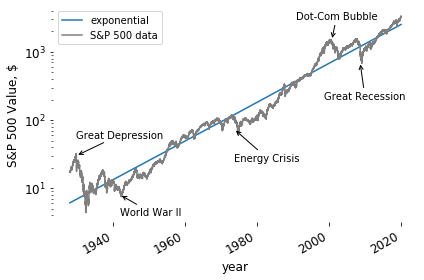

In [8]:
# Create an annotated curve for historical events
fig, ax = plt.subplots()

# Black Tuesday, the market crash that began the Great Depression
black_tuesday = dt.datetime(1929, 10, 29)
ax.annotate('Great Depression', xy=(black_tuesday, 30), xytext=(black_tuesday, 55),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            );

# Pearl Harbor attack
pearl_harbor = dt.datetime(1941, 12, 7)
ax.annotate('World War II', xy=(pearl_harbor, 8), xytext=(pearl_harbor, 4),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            );

# The day OPEC began the oil embargo on the US
energy_crisis = dt.datetime(1973, 10, 1)
ax.annotate('Energy Crisis', xy=(energy_crisis, 73), xytext=(energy_crisis, 25),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            );

# pets.com goes bankrupt nine months after an ~$85mn IPO
pets_dot_com = dt.datetime(2000, 11,9)
pets_dot_com_label = dt.datetime(1990, 11,9)
ax.annotate('Dot-Com Bubble', xy=(pets_dot_com, 1500), xytext=(pets_dot_com_label, 3000),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            );

# Lehman Brothers folds
lehman_brothers = dt.datetime(2008, 9, 20)
lehman_brothers_label = dt.datetime(1998, 9, 20)
ax.annotate('Great Recession', xy=(lehman_brothers, 700), xytext=(lehman_brothers_label, 200),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            );

ax.semilogy(sp500_df.Date, exp_fit, c='tab:blue', label='exponential')
ax.semilogy(sp500_df.Date, sp500_df.Open, c='tab:gray', label='S&P 500 data')
fig.autofmt_xdate()

ax.set_xlabel('year')
ax.set_ylabel('S&P 500 Value, $')

ax.legend();
fig.tight_layout()
fig.savefig('exp_fit_annotated.png', bbox_inches="tight");

print('exponential e-fold growth time = {} years'.format(1/oneOtau))

A few interesting notes

1. This is a pretty good exponential fit, considering this data starts in 1927 and ends in 2020
2. From this, you expect the S&P 500 value to increase e-fold (2.72x) every 10.5 years, which is good to know from a financial planning standpoint

## Normalizing the Growth

We can add back the exponential curve later. Right now we're more interested in the short-term fluctuations. So we subtract off the exponential trend line we computed above, and then divide by that to look at relative fluctuations around the trend line.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


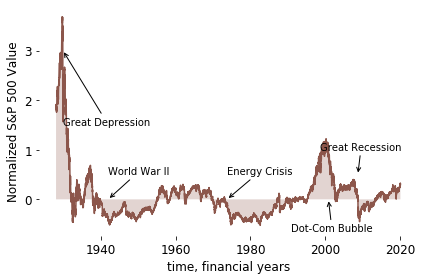

In [9]:
# Create a normed Open value
sp500_df['Open_norm'] = sp500_df['Open']/exp_fit - 1.

fig, ax = plt.subplots()
ax.plot(sp500_df.Date, sp500_df['Open_norm'], c='tab:brown')
ax.fill_between(sp500_df.Date, 0., sp500_df['Open_norm'], facecolor='tab:brown', alpha=0.25)

black_tuesday = dt.datetime(1929, 10, 29)
ax.annotate('Great Depression', xy=(black_tuesday, 3), xytext=(black_tuesday, 1.5),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            )
pearl_harbor = dt.datetime(1941, 12, 7)
ax.annotate('World War II', xy=(pearl_harbor, 0), xytext=(pearl_harbor, .5),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            )

energy_crisis = dt.datetime(1973, 10, 1)
ax.annotate('Energy Crisis', xy=(energy_crisis, 0.), xytext=(energy_crisis, .5),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            )

lehman_brothers = dt.datetime(2008, 9, 20)
lehman_brothers_label = dt.datetime(1998, 9, 20)
ax.annotate('Great Recession', xy=(lehman_brothers, .5), xytext=(lehman_brothers_label, 1.),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            )

pets_dot_com = dt.datetime(2000, 11,9)
pets_dot_com_label = dt.datetime(1990, 11,9)
ax.annotate('Dot-Com Bubble', xy=(pets_dot_com, 0.), xytext=(pets_dot_com_label, -.65),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            )

ax.set_xlabel('time, financial years')
ax.set_ylabel('Normalized S&P 500 Value')
fig.tight_layout()
fig.savefig('sp500_normed.png', bbox_inches="tight")
fig.show();

In the above plot, $0$ means we are right on the exponential curve, and values greater than $0$ are growing ahead of the curve. It's a testament to policy that, after the Great Depression, we got very good at steady long term growth for most of the next hundred years.

# Statistical Properties of the S&P 500

We will now analyze the statistical properties of the S&P 500 on a day-to-day variation. This can be used to build a model for how the market will perform in the future, by building a statistical model for predicting how the market will perform based on the previous day's percentage change. We can then use this model, atop the general exponential trend line, to estimate the range of stock performance over time.

## Day-to-Day Variations in the Market

To analyze day-to-day variations and predict market variances, it would be useful to see if percent changes from day to day are correlated statistically, and to then develop a statistical model for that. First, we add a Pandas column for the percent change from day to day, and then we will look at temporal correlations. 

In [10]:
# compute percent change day to day, and look at some of the data
sp500_df['PercentChange'] = sp500_df['Close'].pct_change()

pc_mean = np.mean(sp500_df.PercentChange)
pc_std = np.std(sp500_df.PercentChange)
pc_max = np.max(sp500_df.PercentChange)
pc_min = np.min(sp500_df.PercentChange)

sp500_df.PercentChange.describe()

count    23134.000000
mean         0.000297
std          0.011841
min         -0.204669
25%         -0.004505
50%          0.000474
75%          0.005384
max          0.166096
Name: PercentChange, dtype: float64

//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


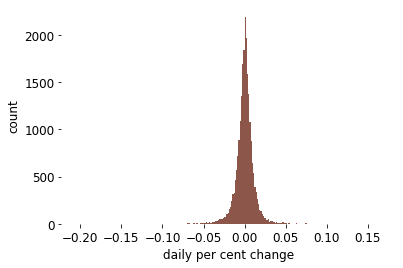

In [11]:
n_bins = 250
fig, ax = plt.subplots()
ax.hist(sp500_df.PercentChange, bins=n_bins, color=tableau20[10])
ax.plot()
ax.set_xlabel(r'daily per cent change')
ax.set_ylabel(r'count')

fig.show();

This does not quite look Gaussian, but possibly an exponential distribution. We will try the two fits from the data.

In [12]:
def exp_fit_func(x, mu, sigma, a):
    return a * np.exp(- np.abs(x - mu)/sigma)

def gauss_fit_func(x, mu, sigma, a):
    return a * np.exp(-(x - mu)**2/(2.*sigma**2))

In [13]:
# get the histogram data
counts, bins = np.histogram(sp500_df.PercentChange, bins=n_bins, range=(pc_min, pc_max))
bins_c = np.array([0.5 * (bins[idx] + bins[idx+1]) for idx in range(len(bins)-1)])

# fit the exponential
popt_exp, pcov_exp = curve_fit(exp_fit_func, xdata=bins_c, ydata=counts, p0=[ pc_mean, pc_std, np.max(counts)])
popt_gauss, pcov_gauss = curve_fit(gauss_fit_func, xdata=bins_c, ydata=counts, p0=[ pc_mean, pc_std, np.max(counts)])

# and compute the residual L2 norm
exp_residual = np.sum(np.abs(exp_fit_func(bins_c, *popt_exp) - counts))
gauss_residual = np.sum(np.abs(gauss_fit_func(bins_c, *popt_gauss) - counts))

# and print the model results
print('exp fit \n mu = {} +/- {} \n sigma = {} +/- {} \n a = {} +/- {}'.format(
    popt_exp[0], pcov_exp[0,0], popt_exp[1], pcov_exp[1,1], popt_exp[2], pcov_exp[2,2]))
print('exp fit residual = {}'.format(exp_residual))

print('gauss fit \n mu = {} +/- {} \n sigma = {} +/- {} \n a = {} +/- {}'.format(
    popt_gauss[0], pcov_gauss[0,0], popt_gauss[1], pcov_gauss[1,1], popt_gauss[2], pcov_gauss[2,2]))
print('gauss fit residual = {}'.format(gauss_residual))

exp fit 
 mu = 0.0006066859891389718 +/- 7.44579767999645e-10 
 sigma = 0.007265497653612161 +/- 2.855086892978554e-09 
 a = 2364.524097241972 +/- 154.4133237932432
exp fit residual = 1675.5629092625543
gauss fit 
 mu = 0.0006289092928853479 +/- 6.341526773373017e-09 
 sigma = 0.00658274263546968 +/- 6.341527374295557e-09 
 a = 1859.0333502081469 +/- 379.32202088447997
gauss fit residual = 4360.066672873471


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


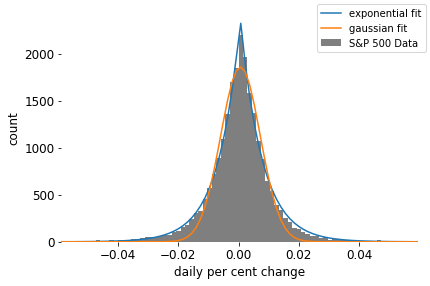

In [14]:
# plot the relative fits
fig, ax = plt.subplots()
ax.bar(bins_c, counts, width=bins[1] - bins[0], alpha=0.5, color='black', label='S&P 500 Data')
ax.plot(bins_c, exp_fit_func(bins_c, *popt_exp), c='tab:blue', label='exponential fit')
ax.plot(bins_c, gauss_fit_func(bins_c, *popt_gauss), c='tab:orange', label='gaussian fit')
ax.set_xlabel(r'daily per cent change')
ax.set_ylabel(r'count')
ax.set_xlim(left=pc_mean-5*pc_std, right=pc_mean+5*pc_std)

fig.legend()
fig.tight_layout()
fig.savefig('percent_change_fit_comparisons.png', bbox_inches="tight")
fig.show();

The exponential fit has a substantially smaller residual, and indeed it seems to capture the sharpness of the peak as well as the width of the tails much better than the gaussian, which underestimates the peak as well as the tails. 

This assumes that performance is completely uncorrelated in time. We will now look at how performance of one day predicts performance the next.

## Day-to-day correlations

Let's look at how the performance of one day will influence the performance the next few days. We can use this to build a time series model predicting probable future performances.

In [15]:
# first, split the historical data into two time-staggered lists
day0 = sp500_df.PercentChange[1:-2]
day1 = sp500_df.PercentChange[2:-1]

# compute the covariance matrix
print('Sigma = \n{}'.format(np.cov([day0, day1])))

Sigma = 
[[ 1.40220834e-04 -1.81241397e-07]
 [-1.81241397e-07  1.40219986e-04]]


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


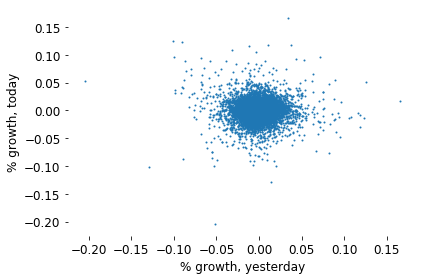

In [16]:
# now, plot a scatter plot of the data
fig, ax = plt.subplots()
ax.scatter(day0, day1, s=1)

ax.set_xlabel('% growth, yesterday')
ax.set_ylabel('% growth, today')

fig.tight_layout()
fig.savefig('time_correlation_percent_growth.png', bbox_inches="tight")
fig.show();